### IEEE 13-Node Test Feeder Power Flow Analysis


This code implements a comprehensive power flow analysis of the IEEE 13-node distribution test feeder, a standard benchmark system used for testing and validating distribution system analysis methods. The implementation closely follows the official IEEE specifications and includes realistic distribution system characteristics.

=== IEEE 13-Node Test Feeder (Dados Oficiais) ===
Barras: [650, 632, 633, 634, 645, 646, 671, 680, 684, 611, 652, 692, 675]
Número de barras: 13
Número de linhas: 12
Barra slack: 650
Barras PQ: [632, 633, 634, 645, 646, 671, 680, 684, 611, 652, 692, 675]
Base de potência: 5.0 MVA
Base de tensão: 4.16 kV (LL), 2.402 kV (LN)
Base de impedância: 1.154 ohms

Cargas do Sistema (kW + j kVAr):
Barra 632: 33.3 kW + j19.3 kVAr
Barra 634: 133.3 kW + j96.7 kVAr
Barra 645: 56.7 kW + j41.7 kVAr
Barra 646: 76.7 kW + j44.0 kVAr
Barra 671: 418.3 kW + j239.3 kVAr
Barra 611: 56.7 kW + j26.7 kVAr
Barra 652: 42.7 kW + j28.7 kVAr
Barra 692: 56.7 kW + j50.3 kVAr
Barra 675: 281.0 kW + j154.0 kVAr

Capacitores do Sistema:
Barra 675: 200.0 kVAr
Barra 611: 33.3 kVAr

Resumo do Sistema:
Carga total: 1155.3 kW + j700.7 kVAr
Capacitores: 233.3 kVAr
Carga líquida: 1155.3 kW + j467.3 kVAr

Valores de referência do documento IEEE:
Carga total sistema: 3466.1 kW + j2101.6 kVAr
Input da subestação: 3577.2 kW + j1724.8 

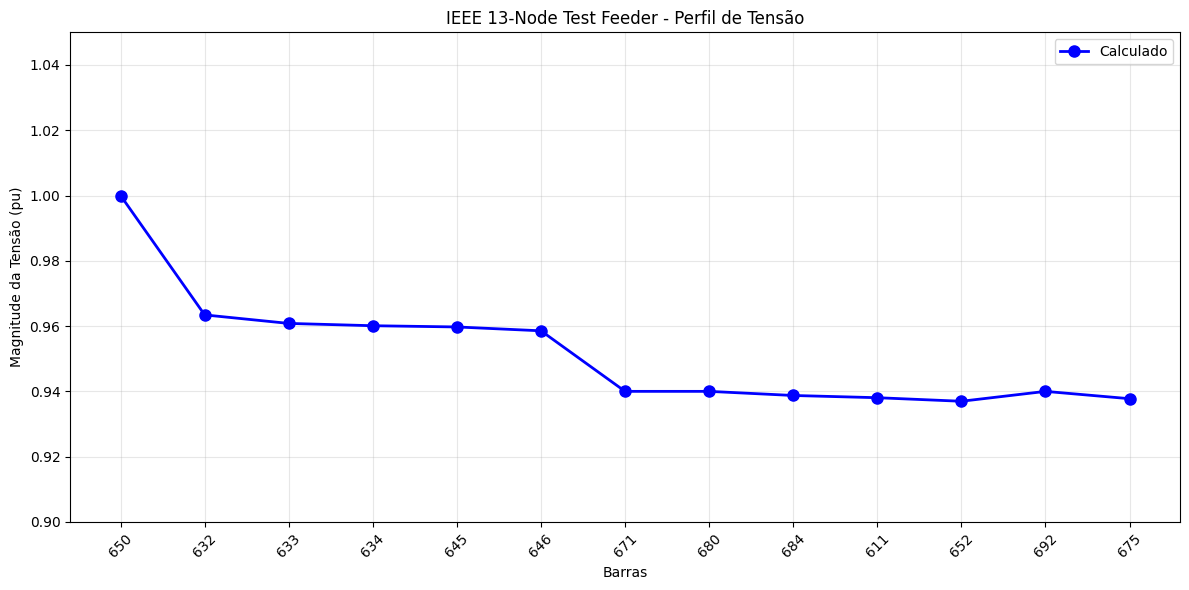

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src.zmatrix_models import MetodoMatrizZdetailed
# Add this function to your code
def print_ybus_formatted(Y_bus, barras):
    """Imprime a matriz Y_bus de forma formatada com nomes das barras"""
    n = len(barras)
    
    print("\n=== Matriz Y_bus Formatada ===")
    print(f"{'Barra':<6}", end='')
    for barra in barras:
        print(f"{barra:>15}", end='')
    print()
    
    for i in range(n):
        print(f"{barras[i]:<6}", end='')
        for j in range(n):
            real = Y_bus[i, j].real
            imag = Y_bus[i, j].imag
            if abs(Y_bus[i, j]) < 1e-10:  # Valores muito pequenos = zero
                print(f"{'0.0000':>15}", end='')
            else:
                print(f"{real:>7.4f}{'+' if imag >= 0 else ''}{imag:.4f}j", end='')
        print()

def print_ybus_formatted_order(Y_bus, barras):
    """Imprime a matriz Y_bus de forma formatada com nomes das barras, com a barra 650 primeiro e o restante em ordem crescente"""
    
    # Índices para barra 650 e outras barras
    idx_650 = [i for i, b in enumerate(barras) if b == 650]
    idx_others = [i for i, b in enumerate(barras) if b != 650]

    # Ordenar os outros índices com base nos valores das barras
    idx_others_sorted = sorted(idx_others, key=lambda i: barras[i])

    # Combinar: 650 primeiro, depois o restante ordenado
    sorted_indices = idx_650 + idx_others_sorted
    sorted_barras = [barras[i] for i in sorted_indices]

    # Reordenar Y_bus
    Y_bus_sorted = Y_bus[np.ix_(sorted_indices, sorted_indices)]

    n = len(sorted_barras)

    print("\n=== Matriz Y_bus Formatada ===")
    print(f"{'Barra':<6}", end='')
    for barra in sorted_barras:
        print(f"{barra:>15}", end='')
    print()

    for i in range(n):
        print(f"{sorted_barras[i]:<6}", end='')
        for j in range(n):
            y = Y_bus_sorted[i, j]
            if abs(y) < 1e-10:
                print(f"{'0.0000':>15}", end='')
            else:
                real = y.real
                imag = y.imag
                print(f"{real:>7.4f}{'+' if imag >= 0 else ''}{imag:.4f}j", end='')
        print()

def ieee_13_node_test_feeder():
    """
    Configuração do sistema IEEE 13-node test feeder
    Baseado nos dados oficiais do IEEE Distribution Test Feeders
    """
    
    # Definir as barras do sistema conforme documento IEEE
    barras = [650, 632, 633, 634, 645, 646, 671, 680, 684, 611, 652, 692, 675]
    
    # Tipos de barras
    # Barra 650 é a barra slack (subestação)
    # Todas as outras são barras PQ (cargas)
    barras_tipo = {
        650: 0,  # Slack bus (subestação)
        632: 2,  # PQ (node intermediário)
        633: 2,  # PQ
        634: 2,  # PQ
        645: 2,  # PQ
        646: 2,  # PQ
        671: 2,  # PQ
        680: 2,  # PQ
        684: 2,  # PQ
        611: 2,  # PQ
        652: 2,  # PQ
        692: 2,  # PQ (switch node)
        675: 2   # PQ
    }
    # barras_tipo = {
    #     611: 2,  # PQ
    #     632: 2,  # PQ (node intermediário)
    #     633: 2,  # PQ
    #     634: 2,  # PQ
    #     645: 2,  # PQ
    #     646: 2,  # PQ
    #     652: 2,  # PQ
    #     671: 2,  # PQ
    #     675: 2,   # PQ
    #     680: 2,  # PQ
    #     684: 2,  # PQ
    #     692: 2,  # PQ (switch node)   
    #     650: 0,  # Slack bus (subestação)

    # }
    
    # Tensões iniciais baseadas nos resultados do documento
    # Tensão base: 4.16 kV (linha-linha), 2.4019 kV (linha-neutro)
    v_base_ll = 4.16  # kV
    v_base_ln = v_base_ll / np.sqrt(3)  # kV linha-neutro
    
    # Tensões iniciais 
    v_inicial = {
        650: 1.0 + 0.0j,  # Tensão da subestação (2% acima do nominal)
        632: 1.0 + 0.0j,
        633: 1.0 + 0.0j,
        634: 1.0 + 0.0j,
        645: 1.0 + 0.0j,
        646: 1.0 + 0.0j,
        671: 1.0 + 0.0j,
        680: 1.0 + 0.0j,
        684: 1.0 + 0.0j,
        611: 1.0 + 0.0j,
        652: 1.0 + 0.0j,
        692: 1.0 + 0.0j,
        675: 1.0 + 0.0j
    }
    
    # Potências das cargas baseadas nos dados do documento
    # Base de potência: 5 MVA (assumida para conversão pu)
    s_base = 5.0  # MVA
    

    potencias = {
        650: 0.0 + 0.0j,                           # Subestação (barra slack)
        632: 0.0 + 0.0j,                           # Sem carga spot (apenas distributed load)
        633: 0.0 + 0.0j,                           # Sem carga spot
        634: (-(160+120+120)/1000/s_base - 1j*(110+90+90)/1000/s_base)/3,  # 400 kW + 290 kVAr
        645: (-170/1000/s_base - 1j*125/1000/s_base)/3,    # 170 kW + 125 kVAr (phase B only)
        646: (-230/1000/s_base - 1j*132/1000/s_base)/3,    # 230 kW + 132 kVAr (phase B only, D-Z)
        671: (-(385+385+385)/1000/s_base - 1j*(220+220+220)/1000/s_base)/3,  # 1155 kW + 660 kVAr (D-PQ)
        680: 0.0 + 0.0j,                           # Sem carga
        684: 0.0 + 0.0j,                           # Sem carga
        611: (-170/1000/s_base - 1j*80/1000/s_base)/3,     # 170 kW + 80 kVAr (phase C, Y-I)
        652: (-128/1000/s_base - 1j*86/1000/s_base)/3,     # 128 kW + 86 kVAr (phase A, Y-Z)
        692: (-170/1000/s_base - 1j*151/1000/s_base)/3,    # 170 kW + 151 kVAr (phase C, D-I)
        675: (-(485+68+290)/1000/s_base - 1j*(190+60+212)/1000/s_base)/3  # 843 kW + 462 kVAr (Y-PQ)
    }
    
    # Distributed load na linha 632-671
    distributed_load = {
        'P': ((17 + 66 + 117)/1000/s_base)/3,  # 200 kW total
        'Q': ((10 + 38 + 68)/1000/s_base)/3    # 116 kVAr total
    }
    
    # Adicionar distributed load dividida entre as barras
    potencias[632] = potencias[632] - 0.5 * (distributed_load['P'] + 1j*distributed_load['Q'])
    potencias[671] = potencias[671] - 0.5 * (distributed_load['P'] + 1j*distributed_load['Q'])
    
    # Conexões do sistema baseadas no Line Segment Data do documento
    linhas = [
        (650, 632),  # 2000 ft, Config 601
        (632, 633),  # 500 ft, Config 602
        (633, 634),  # Transformador XFM-1
        (632, 645),  # 500 ft, Config 603
        (645, 646),  # 300 ft, Config 603
        (632, 671),  # 2000 ft, Config 601
        (671, 684),  # 300 ft, Config 604
        (684, 611),  # 300 ft, Config 605
        (684, 652),  # 800 ft, Config 607
        (671, 680),  # 1000 ft, Config 601
        (671, 692),  # Switch (impedância zero)
        (692, 675)   # 500 ft, Config 606
    ]
    
    # Impedâncias das linhas baseadas nas configurações do documento
    # Convertidas de ohms/mile para pu usando bases de 100 MVA e 4.16 kV
    z_base = (v_base_ln**2) / s_base  # ohms
    
    # Configurações de linha do documento (= em ohms/mile)
    config_impedances = {
        601: (0.1860 + 1j*0.5968),    # Config 601 - overhead 3ph
        602: (0.5921 + 1j*0.7602),    # Config 602 - overhead 3ph  
        603: (1.1200 + 1j*0.8929),    # Config 603 - overhead 2ph
        604: (1.1200 + 1j*0.8929),    # Config 604 - overhead 2ph
        605: (1.3292 + 1j*1.3475),    # Config 605 - overhead 1ph
        606: (0.4874 + 1j*0.4151),    # Config 606 - underground 3ph
        607: (1.3425 + 1j*0.5124)     # Config 607 - underground 1ph
    }
    
    #Impedâncias das linhas em pu
    impedancias_linhas = {
        (650, 632): config_impedances[601] * (2000/5280) / z_base,  # 2000 ft
        (632, 633): config_impedances[602] * (500/5280) / z_base,   # 500 ft
        (633, 634): 0.011 + 1j*0.02,  # Transformador 500 kVA (estimado)
        (632, 645): config_impedances[603] * (500/5280) / z_base,   # 500 ft
        (645, 646): config_impedances[603] * (300/5280) / z_base,   # 300 ft
        (632, 671): config_impedances[601] * (2000/5280) / z_base,  # 2000 ft
        (671, 684): config_impedances[604] * (300/5280) / z_base,   # 300 ft
        (684, 611): config_impedances[605] * (300/5280) / z_base,   # 300 ft
        (684, 652): config_impedances[607] * (800/5280) / z_base,   # 800 ft
        (671, 680): config_impedances[601] * (1000/5280) / z_base,  # 1000 ft
        (671, 692): 0.0001 + 1j*0.0001,  # Switch (impedância muito baixa)
        (692, 675): config_impedances[606] * (500/5280) / z_base    # 500 ft
    }

    
    # Construir matriz de admitância Y_bus
    n_barras = len(barras)
    Y_bus = np.zeros((n_barras, n_barras), dtype=complex)
    
    # Mapear barras para índices
    idx_map = {barra: i for i, barra in enumerate(barras)}
    
    # Capacitores baseados nos dados do documento
    # Convertidos para pu na base de 5 MVA
    capacitores = {
        675: (1j * (200 + 200 + 200) / 1000 / s_base)/3,  # 600 kVAr total
        611: (1j * 100 / 1000 / s_base)/3                  # 100 kVAr
    }
    
    # Preencher matriz Y_bus
    for linha in linhas:
        barra_i, barra_j = linha
        i = idx_map[barra_i]
        j = idx_map[barra_j]
        
        # Admitância série da linha
        z_linha = impedancias_linhas[linha]
        y_linha = 1.0 / z_linha
        
        # Elementos off-diagonal (negativos)
        Y_bus[i, j] = -y_linha
        Y_bus[j, i] = -y_linha
        
        # Elementos diagonais (soma das admitâncias conectadas)
        Y_bus[i, i] += y_linha
        Y_bus[j, j] += y_linha
    
    # Adicionar capacitores (admitâncias shunt)
    for barra, y_cap in capacitores.items():
        i = idx_map[barra]
        Y_bus[i, i] += y_cap
    
    print("=== IEEE 13-Node Test Feeder (Dados Oficiais) ===")
    print(f"Barras: {barras}")
    print(f"Número de barras: {len(barras)}")
    print(f"Número de linhas: {len(linhas)}")
    print(f"Barra slack: {[b for b, t in barras_tipo.items() if t == 0][0]}")
    print(f"Barras PQ: {[b for b, t in barras_tipo.items() if t == 2]}")
    print(f"Base de potência: {s_base} MVA")
    print(f"Base de tensão: {v_base_ll} kV (LL), {v_base_ln:.3f} kV (LN)")
    print(f"Base de impedância: {z_base:.3f} ohms")
    
    print("\nCargas do Sistema (kW + j kVAr):")
    for barra in barras:
        if abs(potencias[barra]) > 0.001:
            P_kW = -potencias[barra].real * s_base * 1000
            Q_kVAr = -potencias[barra].imag * s_base * 1000
            print(f"Barra {barra}: {P_kW:.1f} kW + j{Q_kVAr:.1f} kVAr")
    
    print("\nCapacitores do Sistema:")
    for barra, y_cap in capacitores.items():
        Q_kVAr = y_cap.imag * s_base * 1000
        print(f"Barra {barra}: {Q_kVAr:.1f} kVAr")
    
    # Calcular carga total
    P_total = -sum(p.real for p in potencias.values()) * s_base * 1000
    Q_total = -sum(p.imag for p in potencias.values()) * s_base * 1000
    Q_cap_total = sum(y.imag for y in capacitores.values()) * s_base * 1000
    
    print(f"\nResumo do Sistema:")
    print(f"Carga total: {P_total:.1f} kW + j{Q_total:.1f} kVAr")
    print(f"Capacitores: {Q_cap_total:.1f} kVAr")
    print(f"Carga líquida: {P_total:.1f} kW + j{Q_total-Q_cap_total:.1f} kVAr")
    
    # Valores de referência do documento para comparação
    print(f"\nValores de referência do documento IEEE:")
    print(f"Carga total sistema: 3466.1 kW + j2101.6 kVAr")
    print(f"Input da subestação: 3577.2 kW + j1724.8 kVAr")
    print(f"Perdas do sistema: 111.1 kW + j324.7 kVAr")
    
    print("\nMatriz de Admitância Y_bus (elementos principais):")
    print("Diagonal principal (admitâncias próprias):")
    for i, barra in enumerate(barras[:5]):  # Mostrar apenas as primeiras 5
        real = Y_bus[i, i].real
        imag = Y_bus[i, i].imag
        print(f"Y[{barra},{barra}] = {real:.6f}{'+' if imag >= 0 else ''}{imag:.6f}j")
    
    print_ybus_formatted(Y_bus, barras)
    print_ybus_formatted_order(Y_bus, barras)
    # Modelos de carga baseados nos tipos do documento
    # Y-PQ: Potência constante
    # Y-Z: Impedância constante  
    # Y-I: Corrente constante
    # D-PQ, D-Z, D-I: Delta connection
    load_models = {
        650: {'P': 1.0, 'I': 0.0, 'Z': 0.0},  # Subestação
        632: {'P': 1.0, 'I': 0.0, 'Z': 0.0},  # Sem carga
        633: {'P': 1.0, 'I': 0.0, 'Z': 0.0},  # Sem carga
        634: {'P': 1.0, 'I': 0.0, 'Z': 0.0},  # Y-PQ (potência constante)
        645: {'P': 1.0, 'I': 0.0, 'Z': 0.0},  # Y-PQ (potência constante)
        646: {'P': 0.0, 'I': 0.0, 'Z': 1.0},  # D-Z (impedância constante)
        671: {'P': 1.0, 'I': 0.0, 'Z': 0.0},  # D-PQ (potência constante)
        680: {'P': 1.0, 'I': 0.0, 'Z': 0.0},  # Sem carga
        684: {'P': 1.0, 'I': 0.0, 'Z': 0.0},  # Sem carga
        611: {'P': 0.0, 'I': 1.0, 'Z': 0.0},  # Y-I (corrente constante)
        652: {'P': 0.0, 'I': 0.0, 'Z': 1.0},  # Y-Z (impedância constante)
        692: {'P': 0.0, 'I': 1.0, 'Z': 0.0},  # D-I (corrente constante)
        675: {'P': 1.0, 'I': 0.0, 'Z': 0.0}   # Y-PQ (potência constante)
    }
    
    # Tolerância
    tolerancia = 0.0001
    
    print(f"\n=== Executando Análise de Fluxo de Potência ===")
    print(f"Tolerância: {tolerancia}")
    
    # Criar instância do solver
    solver = MetodoMatrizZdetailed(Y_bus, barras, linhas, barras_tipo, potencias, 
                                 v_inicial, load_models=load_models, tol=tolerancia)
    
    # Resolver usando método da matriz Z com substituição em bloco
    print("\n--- Método de Substituição em Bloco ---")
    v_bloco, v_history_bloco, iteracoes_bloco = solver.substituicao_em_bloco()
    fluxos_bloco = solver.calcular_fluxos(v_bloco)
    
    # Exibir resultados
    solver.exibir_resultados(v_bloco, fluxos_bloco, "Substituição em Bloco", iteracoes_bloco)
    
    # Comparar com valores de referência do documento
    print(f"\n=== Comparação com Valores de Referência IEEE ===")
    print(f"{'Barra':<6} {'V_calc(pu)':<12} {'V_ref(pu)':<12} {'Erro(%)':<10}")
    print("-" * 50)
    
    # Valores de referência do perfil de tensão do documento
    v_ref = {
        650: 1.000,
        632: 1.021,
        633: 1.018,  
        634: 0.994,
        645: 1.033,
        646: 1.031,
        671: 0.990,
        680: 0.990,
        684: 0.988,
        611: 0.974,
        652: 0.983,
        692: 0.990,
        675: 0.983
    }
    
    for i, barra in enumerate(barras):
        v_calc = abs(v_bloco[i])
        v_reference = v_ref[barra]
        erro = abs(v_calc - v_reference) / v_reference * 100
        print(f"{barra:<6} {v_calc:<12.4f} {v_reference:<12.4f} {erro:<10.2f}")
    
    # Plotar perfil de tensão
    plt.figure(figsize=(12, 6))
    v_magnitudes = [abs(v) for v in v_bloco]
    v_ref_values = [v_ref[barra] for barra in barras]
    
    x = range(len(barras))
    plt.plot(x, v_magnitudes, 'bo-', label='Calculado', linewidth=2, markersize=8)
    #plt.plot(x, v_ref_values, 'rs--', label='Referência IEEE', linewidth=2, markersize=8)
    
    plt.xlabel('Barras')
    plt.ylabel('Magnitude da Tensão (pu)')
    plt.title('IEEE 13-Node Test Feeder - Perfil de Tensão')
    plt.xticks(x, [str(b) for b in barras], rotation=45)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.ylim(0.90, 1.05)
    plt.tight_layout()
    plt.show()
    
    return solver, v_bloco, fluxos_bloco

# Executar o sistema IEEE 13-node
if __name__ == "__main__":
    solver, tensoes, fluxos = ieee_13_node_test_feeder()